In [2]:
import pandas as pd
import numpy as np
import scipy.stats
from sklearn.datasets import load_boston

import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
import seaborn as sns
from mpl_toolkits.mplot3d import axes3d, Axes3D
%matplotlib notebook

from ipywidgets import interactive
import ipywidgets as widgets

# Other Considerations in the Regression Model

This is the continuation of the http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf

## Qualitative Predictors


In [52]:
df = pd.read_csv('./data/credit.csv', index_col = 0)
df.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


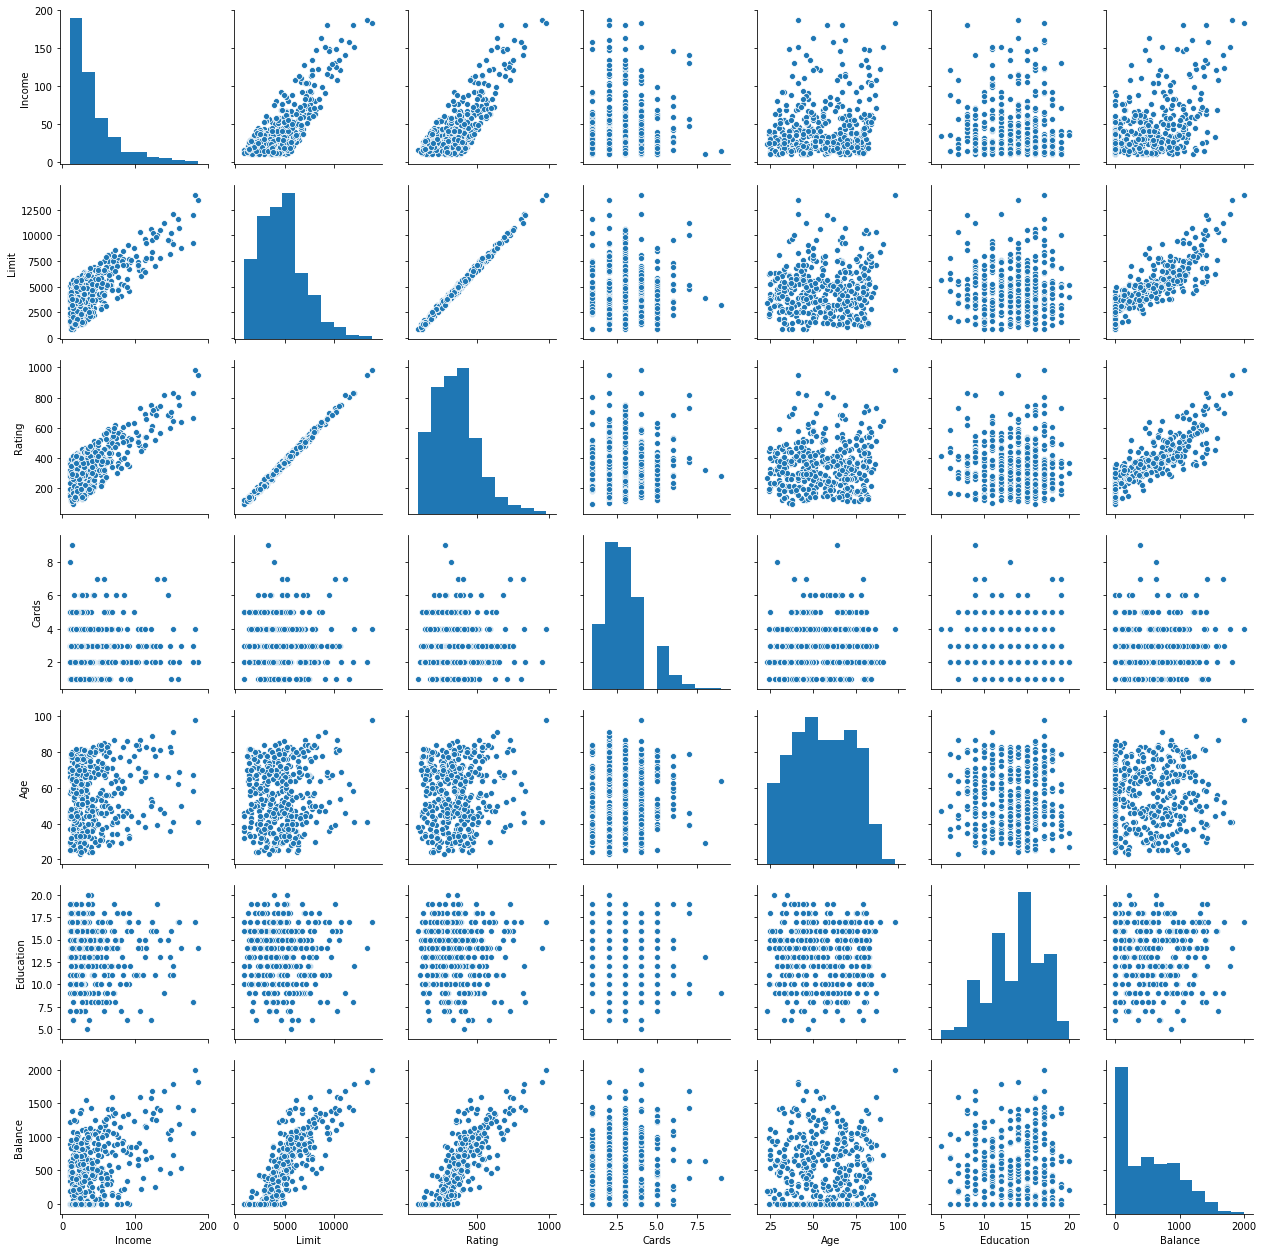

In [53]:
%matplotlib inline
sns.pairplot(df)

## Predictors with two levels

Let us investigate the effect of gender onto balance:

In [58]:
df.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


Let us investigate difference in balance based on gender. First, let us see the average balance per gender:

In [94]:
df.groupby('Gender')['Balance'].mean()

Gender
 Male     509.803109
Female    529.536232
Name: Balance, dtype: float64

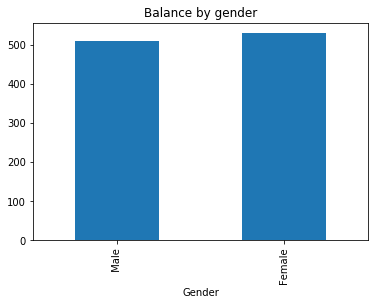

In [96]:
df.groupby('Gender')['Balance'].mean().plot(title = 'Balance by gender', kind = 'bar')

Replace gender text with a number 0 -- Female and 1 -- Male:

In [109]:
def replace_gender(g):
    if g == 'Female':
        return 1
    else:
        return -1

X = df['Gender'].apply(replace_gender).values.reshape([-1,1])
y = df['Balance'].values
X.shape,y.shape

((400, 1), (400,))

In [98]:
# This is another option
#X = (df['Gender'].str.contains('Female')).astype(int).values.reshape([-1,1])

((400, 1), (400,))

In [112]:
def multiple_regression_stats(X,y):
    n, p = X.shape
    _X = np.ones([n,p+1]) # add an extra column = 1 for the intercept
    _X[:,1:] = X[:]
    
    XT = np.transpose(_X)
    XTX = np.dot(XT,_X)
    invXTX = np.linalg.inv(XTX)
    beta = np.dot(np.dot(invXTX,XT),y)
    
    y_hat = np.dot(_X, beta)
    RSS = np.sum((y-y_hat)**2)
    RSE = np.sqrt(RSS/(n-p-1))
    
    TSS = np.sum((y-np.mean(y))**2)
    R2 = 1 - RSS/TSS
    
    var_e = (1/(X.shape[0]-2-p))*RSS # sigma^2
    v = np.diag(np.linalg.inv(XTX))
    t_stat = beta/(np.sqrt(var_e)*np.sqrt(v))
    p_values = tuple([(1-scipy.stats.norm(0,1).cdf(np.abs(t)))*2 for t in t_stat])
    
    return dict({
        'coefficients':beta
        ,'t-stats':t_stat
        ,'p_values':p_values
        ,'R^2':R2
        ,'TSS':TSS
        ,'RSS':RSS
        ,'RSE':RSE
        ,'y_hat':y_hat
    })

r = multiple_regression_stats(X,y)
r['coefficients'],r['t-stats'],r['p_values']

(array([519.66967035,   9.86656154]),
 array([22.5408369 ,  0.42796524]),
 (0.0, 0.6686764287419669))

## Qualitative Predictors with More than Two Levels

We first produce binary variables for each value of the qualitative predictor:

In [118]:
df_ethnicity = pd.get_dummies(df['Ethnicity'])
df_ethnicity.head()

,African American,Asian,Caucasian
0,0,0,1
1,0,1,0
2,0,1,0
3,0,1,0
4,0,0,1


One of the variables is not needed, as it is dependent on two others. If we keep it, it will result in a singular matrix. Check!

In [123]:
X = df_ethnicity[['Asian','Caucasian']].values
y = df['Balance']
X.shape, y.shape

((400, 2), (400,))

In [125]:
r = multiple_regression_stats(X,y)
r['coefficients'],r['t-stats'],r['p_values']

(array([531.        , -18.68627451, -12.50251256]),
 array([11.44960907, -0.28702579, -0.22029865]),
 (0.0, 0.7740925740771827, 0.8256385685796612))

Here is the model: 

$Balance = 531 - 18.69*Asian - 12.50*Caucasian$

However, the p-values are large, so there is no statistical evidence of a real difference in credit card balance between the ethnicities.

## Extensions of the Linear Model

The linear regression model has two assumptions of the relationship between the predictors and response:

* it is linear
* it is additive

### Removing the Additive Assumption

In [139]:
df = pd.read_csv('./data/Advertising.csv')
df.head()

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In [140]:
r = multiple_regression_stats(df[['TV','Radio']],df['Sales'])
r['coefficients'],r['t-stats'],r['p_values'],r['R^2']

(array([2.92109991, 0.04575482, 0.18799423]),
 array([ 9.89398521, 32.82507735, 23.3230242 ]),
 (0.0, 0.0, 0.0),
 0.8971942610828956)

The figure below illustrates that TV and Radio are not independent. This is also known as *synergy* effect (marketing) or *interaction* effect (statistics). Note how the linear regression overestimates the Sales when *either* the Radio or TV is low:

<IPython.core.display.Javascript object>


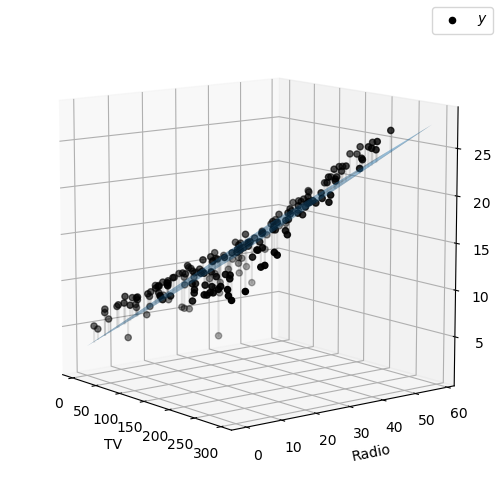

In [131]:
%matplotlib notebook

TV = np.arange(0,300,2)
Radio = np.arange(0,60,2)
TV, Radio = np.meshgrid(TV, Radio)
b0, b1, b2 = r['coefficients']
y_hat_plane = b0+b1*TV+b2*Radio

fig = plt.figure(figsize = (5,5))
ax = Axes3D(fig, azim = 0, elev = 0)
ax.plot_surface(TV, Radio, y_hat_plane
                ,rstride=10, cstride=10,shade=True,alpha = 0.5)
ax.scatter(df['TV'],df['Radio'],df['Sales']
           , label = '$y$', color = 'black'
          , marker = 'o')
          
for i in range(df.shape[0]):
    ax.plot((df.loc[i,'TV'],df.loc[i,'TV'])
            ,(df.loc[i,'Radio'],df.loc[i,'Radio'])
            ,(df.loc[i,'Sales'],r['y_hat'][i])
           ,color = 'black',alpha=0.1)

ax.set_xlabel('TV')
ax.set_ylabel('Radio')
ax.set_zlabel('Sales')
ax.legend()
plt.show()


To mitigate the problem, let us build a model like this:

$Y = \beta_0 + \beta_1X_1 + \beta_2X_2 + \beta_3X_1X_2+\epsilon$

Here is what the modified data will look like:

In [141]:
df['TVxRadio'] = df.TV*df.Radio
df.head()

,Unnamed: 0,TV,Radio,Newspaper,Sales,TVxRadio
0,1,230.1,37.8,69.2,22.1,8697.78
1,2,44.5,39.3,45.1,10.4,1748.85
2,3,17.2,45.9,69.3,9.3,789.48
3,4,151.5,41.3,58.5,18.5,6256.95
4,5,180.8,10.8,58.4,12.9,1952.64


In [142]:
r = multiple_regression_stats(df[['TV','Radio','TVxRadio']],df['Sales'])
r['coefficients'],r['t-stats'],r['p_values'],r['R^2']

(array([6.75022020e+00, 1.91010738e-02, 2.88603399e-02, 1.08649470e-03]),
 array([27.1631945 , 12.66651676,  3.23253682, 20.67362268]),
 (0.0, 0.0, 0.0012269632216475035, 0.0),
 0.9677905498482523)

Note that the p-value for the Radio is now: 0.001 (it is high). According to the hierarchical principle, *if we include an interaction in a model, we should also include the main effects, even if the p-values associated with the coefficients are not significant.*

### Interaction between qualitative and quantitative variables

Let us consider the balance as a result of income and student variables:

In [145]:
df = pd.read_csv('./data/credit.csv')
df.head()

,Unnamed: 0,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,2,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,3,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


In [150]:
df['Student_dummy'] = df.Student.str.contains('Yes').astype(int)
df['Income x Student'] = df.Income*df.Student_dummy
df.head()

,Unnamed: 0,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance,Student_dummy,Income x Student
0,0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333,0,0.000
1,1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903,1,106.025
2,2,104.593,7075,514,4,71,11,Male,No,No,Asian,580,0,0.000
3,3,148.924,9504,681,3,36,11,Female,No,No,Asian,964,0,0.000
4,4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331,0,0.000


In [158]:
# linear regression with interaction
r1 = multiple_regression_stats(df[['Student_dummy', 'Income', 'Income x Student']],df['Balance'])
r1['coefficients'],r1['t-stats'],r1['p_values'],r1['R^2']

(array([200.62315295, 476.67584321,   6.21816874,  -1.99915087]),
 array([ 5.94597535,  4.56222346, 10.48873491, -1.15328449]),
 (2.7481550368690932e-09, 5.061473659084825e-06, 0.0, 0.2487936335177472),
 0.27988370306198973)

In [159]:
# linear regression WITHOUT interaction
r2 = multiple_regression_stats(df[['Student_dummy', 'Income']],df['Balance'])
r2['coefficients'],r2['t-stats'],r2['p_values'],r2['R^2']

(array([211.1429644 , 382.67053884,   5.98433557]),
 array([ 6.49707307,  5.85183819, 10.73759392]),
 (8.1897599812919e-11, 4.861694824498386e-09, 0.0),
 0.27745888896675686)

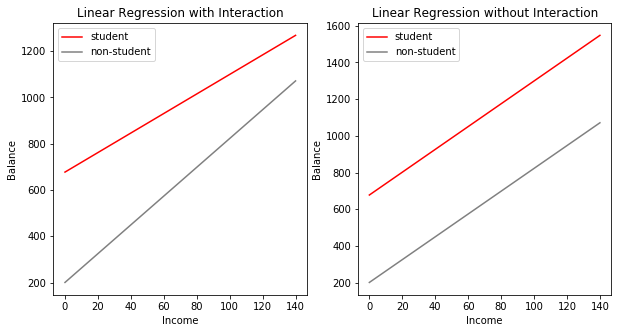

In [170]:
# model with interaction
b0, b1, b2, b3 = r1['coefficients']
Income = np.arange(0,150,10)
Balance1 = b0+b1*1+b2*Income+b3*Income*1 # Student = 1
Balance2 = b0+b1*0+b2*Income+b3*Income*0 # Student = 0

# model without interaction
b0_1, b1_1, b2_1 = r2['coefficients']
Income = np.arange(0,150,10)
Balance1_1 = b0+b1*1+b2*Income # Student = 1
Balance2_1 = b0+b1*0+b2*Income # Student = 0


%matplotlib inline
plt.figure(figsize = (10,5))
ax = plt.subplot(1,2,1)
ax.set_title('Linear Regression with Interaction')
ax.plot(Income, Balance1, color = 'red', label = 'student')
ax.plot(Income, Balance2, color = 'gray', label = 'non-student')
ax.set_xlabel('Income')
ax.set_ylabel('Balance')
ax.legend()

ax = plt.subplot(1,2,2)
ax.set_title('Linear Regression without Interaction')
ax.plot(Income, Balance1_1, color = 'red', label = 'student')
ax.plot(Income, Balance2_1, color = 'gray', label = 'non-student')
ax.set_xlabel('Income')
ax.set_ylabel('Balance')
ax.legend()

plt.show()

## Non-linear Relationships

Let us apply a generalized approach known as polynomial regression:

In [172]:
df = pd.read_csv('./data/auto.csv')
df.head()

,Unnamed: 0,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,1,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,2,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,3,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,4,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,5,17.0,8,302.0,140,3449,10.5,70,1,ford torino


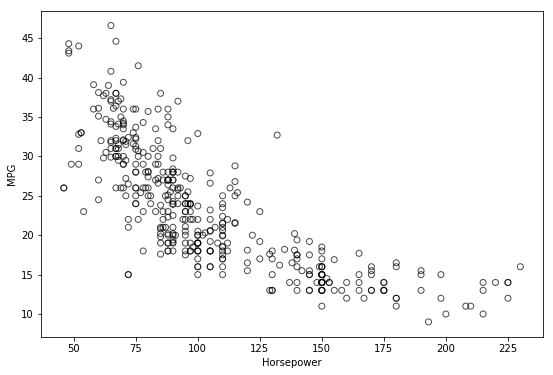

In [206]:
plt.figure(figsize = (9,6))
plt.scatter(df['horsepower'],df['mpg'],facecolors='none', edgecolors='black', 
            color = 'black', alpha = 0.7, label = 'data')
plt.xlabel('Horsepower')
plt.ylabel('MPG')
plt.show()

In [178]:
df['hp^2'] = df.horsepower**2
df['hp^3'] = df.horsepower**3
df['hp^4'] = df.horsepower**4
df['hp^5'] = df.horsepower**5

In [189]:
hp = np.arange(50,230,1)
hp2, hp3, hp4, hp5 = hp**2, hp**3, hp**4, hp**5

r1 = multiple_regression_stats(df[['horsepower']],df['mpg'])
b0, b1 = r1['coefficients']
mpg1 = b0+b1*hp

r2 = multiple_regression_stats(df[['horsepower','hp^2']],df['mpg'])
b0, b1, b2 = r2['coefficients']
mpg2 = b0+b1*hp+b2*hp2

r5 = multiple_regression_stats(df[['horsepower','hp^2','hp^3','hp^4','hp^5']],df['mpg'])
b0, b1, b2, b3, b4, b5 = r5['coefficients']
mpg5 = b0+b1*hp+b2*hp2+b3*hp3+b4*hp4+b5*hp5


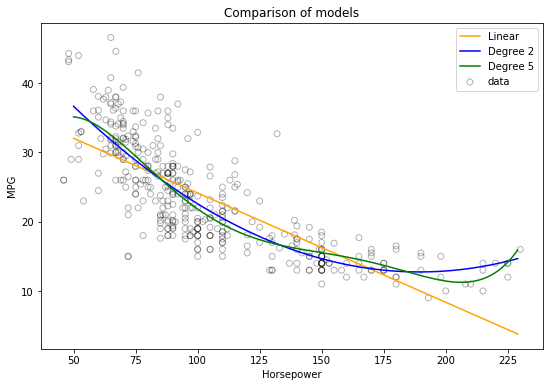

In [261]:
plt.figure(figsize = (9,6))
plt.title('Comparison of models')
plt.scatter(df['horsepower'],df['mpg'],facecolors='none', edgecolors='black', 
            color = 'black', alpha = 0.3, label = 'data')
plt.plot(hp, mpg1, label = 'Linear', color = 'orange')
plt.plot(hp, mpg2, label = 'Degree 2', color = 'blue')
plt.plot(hp, mpg5, label = 'Degree 5', color = 'green')
plt.xlabel('Horsepower')
plt.ylabel('MPG')
plt.legend()
plt.show()

In [262]:
r1['R^2'],r2['R^2'],r5['R^2']

(0.6059482578894348, 0.6875590305127515, 0.6967390038966403)

Linear regression with a quadratic term:

|              | Coefficient | t-statistic | p-value |
|--------------|-------------|-------------|---------|
| Intercept    | 56.9001     | 31.6        | <0.0001 |
| horsepower   | -0.4662     | -15.0       | <0.0001 | 
| horsepower^2 | 0.0012      | 10.1        | <0.0001 |

$mpg = 56.9001 -0.4662*horsepower + 0.0012*horsepower^2 + \epsilon$

## Potential Problems

1. Non-linearity of the response-predictor relationships
2. Correlation of error terms
3. Non-constant variance of error terms
4. Outliers
5. High-leverage points
6. Collinearity

### 1. Non-linearity of the Data

Use residual plots for identifying non-linearity:

$e_i = y_i - \hat{y}_i$ versus the predictor $x_i$ or versus the fitted values $y_i$.

We will use the previously fit models to illustrate:

Text(0.5, 1.0, 'Linear regression with terms up to degree 5')

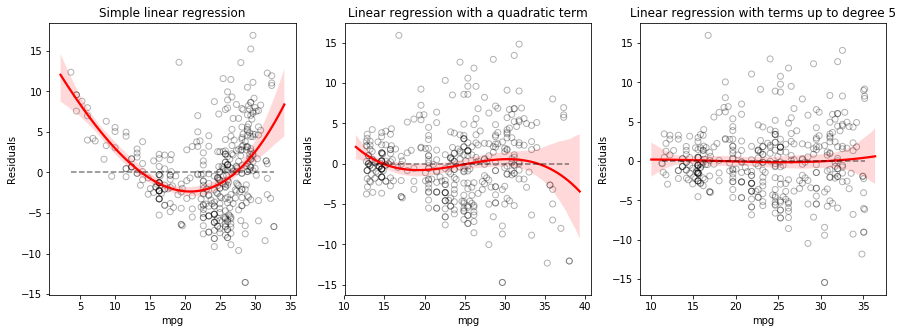

In [348]:
%matplotlib inline

def draw_residuals(ax, y_hat, e, x_label = 'mpg'):
    sns.regplot(y_hat,e
                , ax = ax
                , scatter_kws = {'color':'black', 'alpha':0.3, 'facecolors':'none','edgecolors':'black'}
                , line_kws = {'color':'red'}
                , order = 3
               )
    x_lims = y_hat.min(), y_hat.max()
    y_lims = (0,0)
    ax.plot(x_lims,y_lims, '--', color = 'black', alpha = 0.5)
    ax.set_xlabel(x_label)
    ax.set_ylabel('Residuals')

plt.figure(figsize = (15,5))
ax = plt.subplot(1,3,1)
draw_residuals(ax,r1['y_hat'], df['mpg']-r1['y_hat'])
ax.set_title('Simple linear regression')
ax = plt.subplot(1,3,2)
draw_residuals(ax,r2['y_hat'], df['mpg']-r2['y_hat'])
ax.set_title('Linear regression with a quadratic term')
ax = plt.subplot(1,3,3)
draw_residuals(ax,r5['y_hat'], df['mpg']-r5['y_hat'])
ax.set_title('Linear regression with terms up to degree 5')

The simple linear regression has a pattern in the residuals. 

### 2. Correlation of Error Terms

The standard errors are based on assumption that $\epsilon_1, \epsilon_2, ..., \epsilon_n$ are uncorrelated. If they are, the confidence intervals will be higher and the p-values will get underestimated. This may make us erroneously conclude that a parameter is statistically significant, while in reality it is not. 

Let us illustrate the concept on an example of synthetic time series data:

In [349]:
def get_synthetic_residuals(std, num_points = 100):
    e = np.cumsum(np.random.normal(0,1,num_points))+np.random.normal(0,std,num_points)
    cc, p = scipy.stats.pearsonr(e[:-1],e[1:]) 
    return dict({'cc':cc,'p':p,'residuals':e})

get_synthetic_residuals(0, num_points = 10)

{'cc': 0.7599098382421279,
 'p': 0.017493412294893377,
 'residuals': array([-0.39096858,  2.33577022,  0.22139092, -1.23689943, -4.90052527,
        -4.63387577, -5.41481857, -3.37989784, -5.77928463, -6.83222513])}

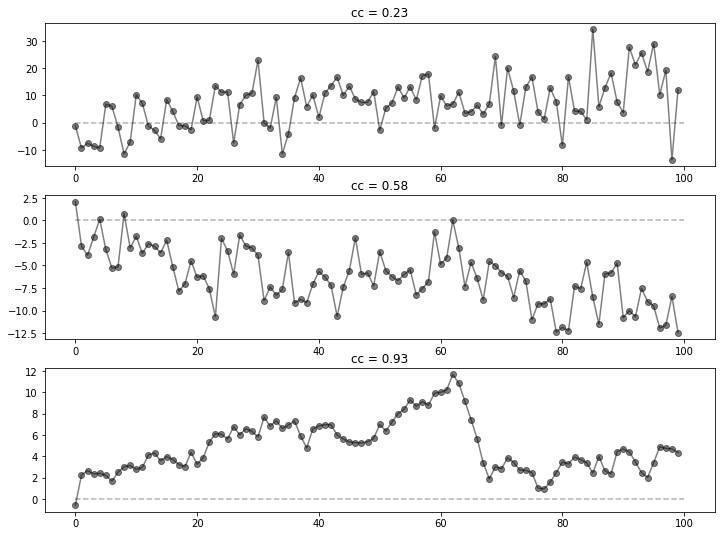

In [350]:
%matplotlib inline
plt.figure(figsize = (12,9))

for i,std in enumerate([8.0,2.0,0.1]):
    ax = plt.subplot(3,1,i+1)
    e = get_synthetic_residuals(std)
    ax.plot(e['residuals'], color = 'black', marker = 'o', alpha = 0.5)
    ax.plot((0,100),(0,0), '--',color = 'black', alpha = 0.3)
    ax.set_title('cc = %.2f'%e['cc'])
    
plt.show()

### 3. Non-constant Variance of Error Terms

Heteroscedasticity, or non-constant variance of the error terms may look like a *funnel* shape in the residual plot. To illustrate the case, let us get back to the Horsepower -- MPG model:

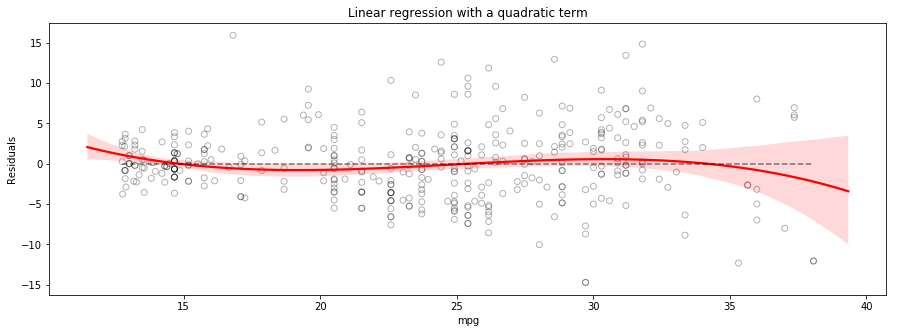

In [352]:
%matplotlib inline

plt.figure(figsize = (15,5))
ax = plt.subplot(1,1,1)
draw_residuals(ax,r2['y_hat'], df['mpg']-r2['y_hat'])
ax.set_title('Linear regression with a quadratic term')
plt.show()

The variance of errors varies based on mpg:

In [353]:
e = df['mpg']-r2['y_hat']
df['e'] = e
[(mpg,df[(df.mpg > mpg-5) & (df.mpg < mpg+5)].e.var()) for mpg in range(10,40,5)]

[(10, 1.7771582590327664),
 (15, 11.044993333257281),
 (20, 11.839560068555592),
 (25, 14.061183783131519),
 (30, 15.56760173146407),
 (35, 14.689081502006598)]

We can attempt to address it by fitting the linear regression to $\sqrt{mpg}$ and $\log\left(mpg\right)$

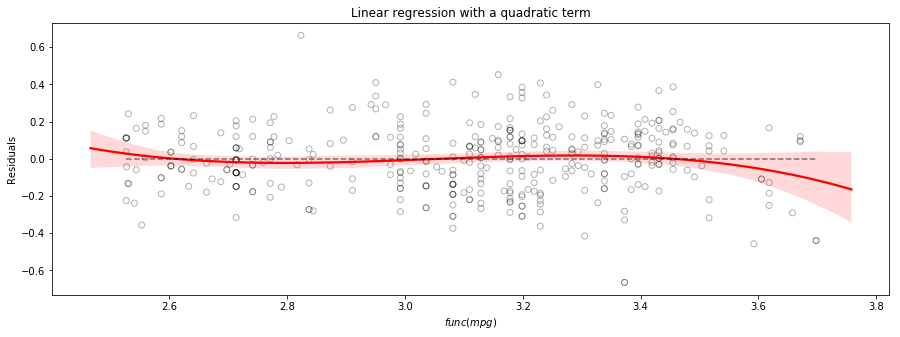

In [358]:
%matplotlib inline

func = np.log # change this to np.sqrt to test out the square root
r2_func = multiple_regression_stats(df[['horsepower','hp^2']],func(df['mpg']))

plt.figure(figsize = (15,5))
ax = plt.subplot(1,1,1)
draw_residuals(ax, r2_func['y_hat'], func(df['mpg'])-r2_func['y_hat'], x_label = r'$func\left(mpg\right)$')
ax.set_title('Linear regression with a quadratic term')
plt.show()

The transformed residuals seem to have less or no heteroscedacity:

In [359]:
e = func(df['mpg'])-r2['y_hat']
df['e'] = e
[(mpg,df[(df.mpg > mpg-5) & (df.mpg < mpg+5)].e.var()) for mpg in range(10,40,5)]

[(10, 1.213507007816894),
 (15, 18.27643038923422),
 (20, 17.748386364200194),
 (25, 15.431871434387046),
 (30, 15.042971086894784),
 (35, 10.409582963029273)]

### 4. Outliers

An outlier is a point $y_i$ far from its prediction $\hat{y}_i$. This can be due to a measurement error or due to other effects in data. 

For instance the residual plot below helps to find an outlier at mpg = 17:

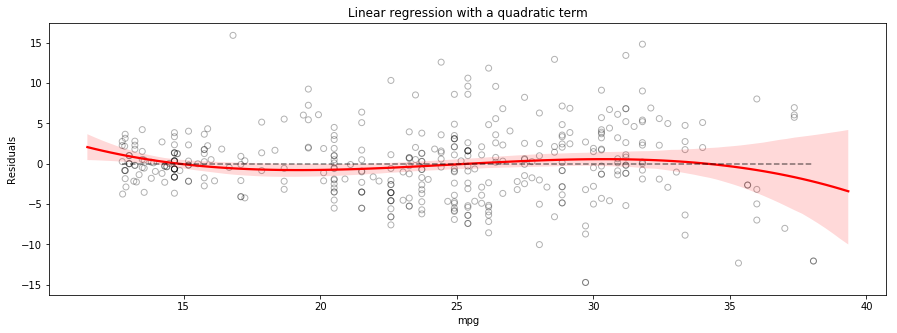

In [368]:
%matplotlib inline

r2 = multiple_regression_stats(df[['horsepower','hp^2']],df['mpg'])

plt.figure(figsize = (15,5))
ax = plt.subplot(1,1,1)
draw_residuals(ax, r2['y_hat'], df['mpg']-r2['y_hat'])
ax.set_title('Linear regression with a quadratic term')
plt.show()

Let us find it in the data:

In [374]:
df['y_hat'] = r2['y_hat']
df[df['mpg']-r2['y_hat'] > 15]

,Unnamed: 0,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,hp^2,hp^3,hp^4,hp^5,e,y_hat
330,334,32.7,6,168.0,132,2910,11.4,80,3,datsun 280-zx,17424,2299968,303595776,40074642432,15.89607,16.80393


In [373]:
168.0*(2.54**3)

2753.026752

The outlier is a 1980 Datsun 280 zx, which can be due to its low drag coefficient or a turbo charged engine. 

![](https://cdn.bringatrailer.com/wp-content/uploads/2017/02/Screen-Shot-2017-03-29-at-10.14.37-AM-940x609.png)

### 5. High Leverage Points

High leverage points have an unusual value of $x_i$. 

Let us illustrate this on synthetic data. Try it several times to see the effects.

In [392]:
num_points = 20
X1 = np.random.normal(0,1,num_points)
X1[0] = np.random.normal(0,15,1)
Y1 = X1+np.random.normal(0,0.5,num_points)

In [393]:
r1 = multiple_regression_stats(X1[1:].reshape([-1,1]),Y1[1:]) # without the leverage point
r2 = multiple_regression_stats(X1.reshape([-1,1]),Y1) # with the leverage point

In [394]:
r1['coefficients'], r2['coefficients']

(array([0.04562808, 0.99520722]), array([0.0446451, 0.9584705]))

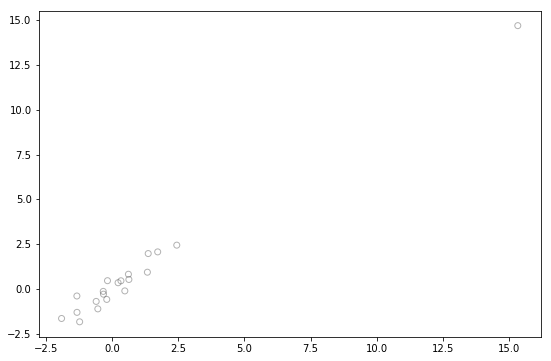

In [395]:
plt.figure(figsize = (9,6))
ax = plt.subplot(1,1,1)
ax.scatter(X1,Y1,facecolors='none', edgecolors='black', 
            color = 'black', alpha = 0.3, label = 'data')
#plt.plot(hp, mpg1, label = 'Linear', color = 'orange')
#plt.plot(hp, mpg2, label = 'Degree 2', color = 'blue')
#plt.plot(hp, mpg5, label = 'Degree 5', color = 'green')
#plt.xlabel('Horsepower')
#plt.ylabel('MPG')
#plt.legend()
plt.show()